In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
import csv

In [3]:
row_start = 14

In [4]:
# metadata = dict()
filename = "1B - Adrian - new.CSV"
with open(filename, newline='') as csvfile:
    reader = csv.reader(csvfile)

In [5]:
data = pd.read_csv(filename, delimiter=",", header=row_start)
data

,TIME,CH1,CH1 Peak Detect,CH2,CH2 Peak Detect
0,-2.00000,9.88,10.04,1.400,1.400
1,-1.99997,9.96,9.80,1.400,1.400
2,-1.99994,9.96,10.04,1.400,1.400
3,-1.99990,9.88,9.80,1.400,1.400
4,-1.99987,9.88,10.04,1.400,1.400
...,...,...,...,...,...
124995,1.99984,0.12,-0.04,0.032,0.016
124996,1.99987,0.12,0.20,0.032,0.056
124997,1.99990,0.04,-0.04,0.032,0.016
124998,1.99994,0.04,0.20,0.032,0.056


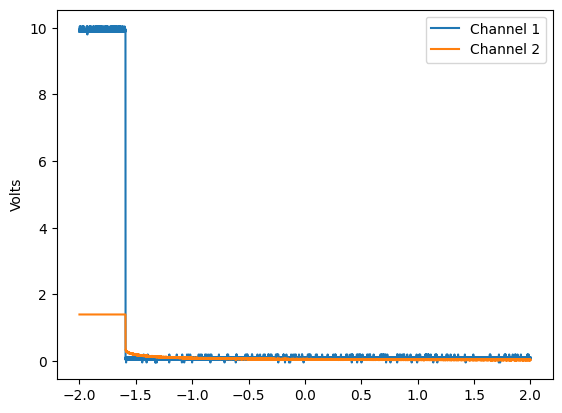

In [6]:
t_raw = data["TIME"]
ch1_raw = data["CH1"]
ch2_raw = data["CH2"]
plt.plot(
    t_raw, 
    ch1_raw,
    label="Channel 1"
)
plt.plot(
    t_raw, 
    ch2_raw,
    label="Channel 2"
)
plt.ylabel("Volts")
plt.legend()


Text(0.5, 0, 'Time (s)')

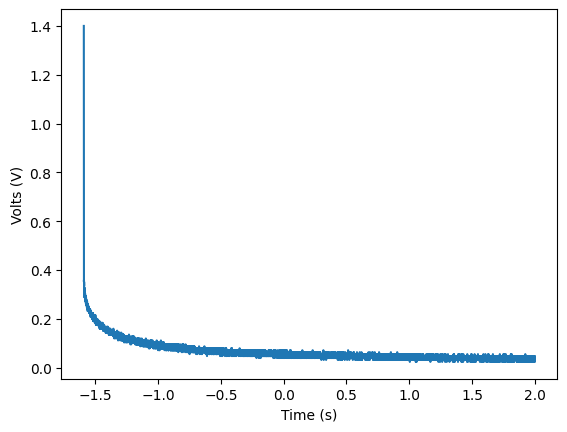

In [7]:
t = t_raw[ch1_raw < 1]
ch2_noisy = ch2_raw[ch1_raw < 1]
plt.plot(t, ch2_noisy)
plt.ylabel("Volts (V)")
plt.xlabel("Time (s)")

In [8]:
from scipy import signal

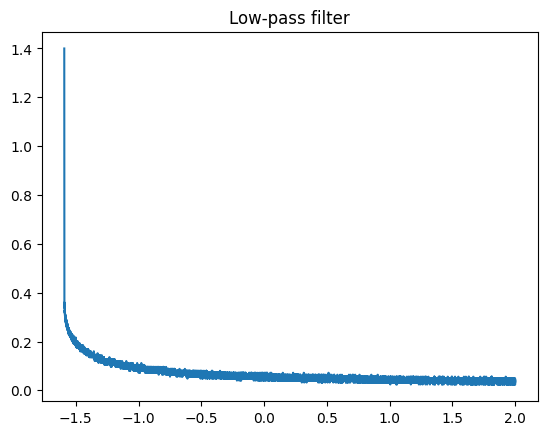

In [9]:
sample_frequency = 2e8
cutoff_frequency = 1e6
b, a = signal.butter(1, 2*cutoff_frequency/sample_frequency)
#ch2 = signal.filtfilt(b, a, ch2_noisy)
ch2 = ch2_noisy
plt.plot(t, ch2)
plt.title("Low-pass filter")
plt.show()

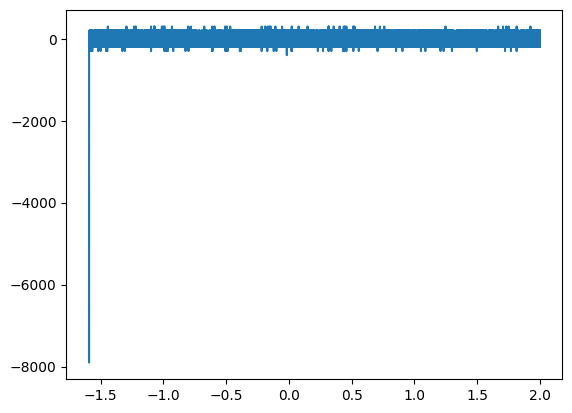

In [10]:
dt = np.array(t)[1] - np.array(t)[0]
dch2dt = np.gradient(ch2, dt)
plt.plot(t, dch2dt)

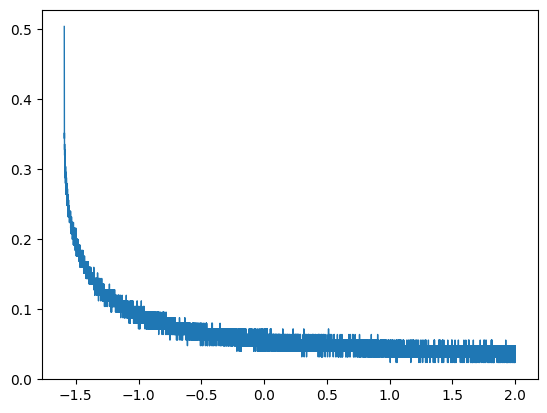

In [11]:
t_truncated = t[dch2dt>-1000]
ch2_truncated = ch2[dch2dt>-1000]
plt.plot(t_truncated, ch2_truncated,lw=1)

In [12]:
model = lambda t, A, RC, z: A * np.exp(-t/RC) + z
[A_model, RC_model, z_model], cov = sp.optimize.curve_fit(model, t, ch2)
cov

array([[ 4.25747675e-10,  1.29857158e-08, -5.02260151e-10],
       [ 1.29857158e-08,  4.02752466e-07, -1.41907812e-08],
       [-5.02260151e-10, -1.41907812e-08,  1.79871354e-09]])

Text(0.5, 1.0, "Voltage vs. Time for Adrian's Capacitor")

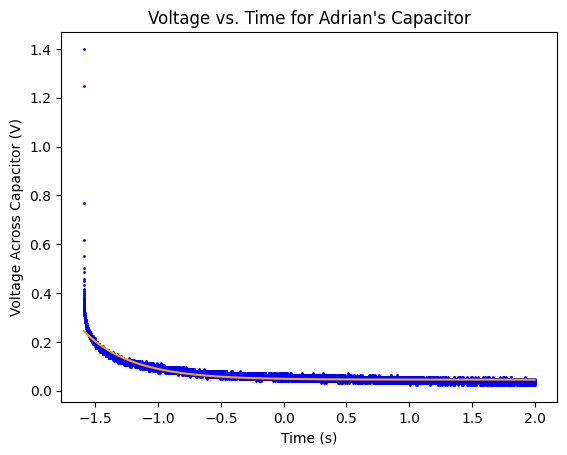

In [32]:
plt.scatter(t, ch2, c='blue', s=1)
plt.plot(t, model(t, A_model, RC_model, z_model), c='orange')
plt.xlabel("Time (s)")
plt.ylabel("Voltage Across Capacitor (V)")
plt.title("Voltage vs. Time for Adrian's Capacitor")

Text(0.5, 1.0, "Voltage vs. Time Residual for Adrian's Capacitor")

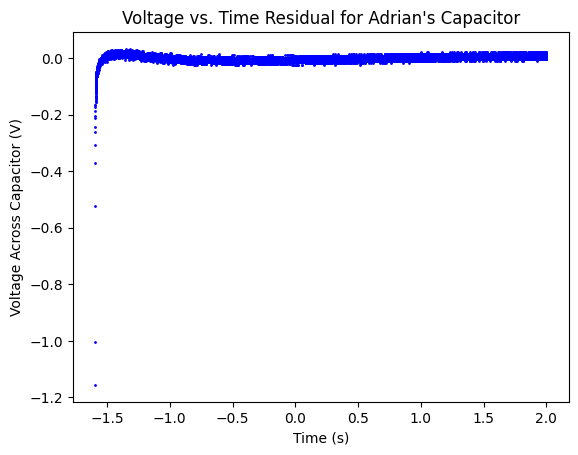

In [33]:
residual = model(t, A_model, RC_model, z_model) - ch2
plt.scatter(t, residual, c='blue', s=1)
plt.xlabel("Time (s)")
plt.ylabel("Voltage Across Capacitor (V)")
plt.title("Voltage vs. Time Residual for Adrian's Capacitor")

Text(0.5, 1.0, "Voltage vs. Time Fractional Residual for Adrian's Capacitor")

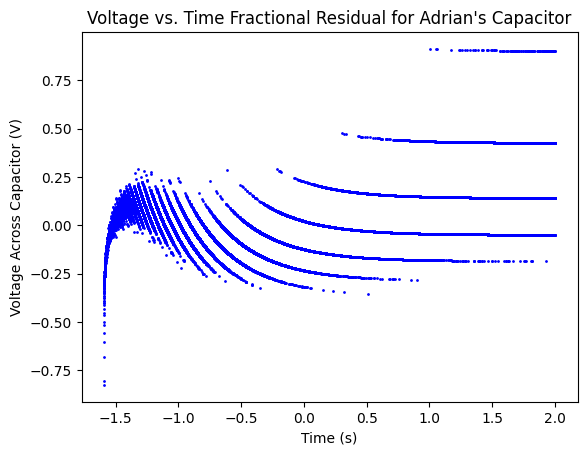

In [36]:
plt.scatter(t, residual / ch2, s=1, c='blue')
plt.xlabel("Time (s)")
plt.ylabel("Voltage Across Capacitor (V)")
plt.title("Voltage vs. Time Fractional Residual for Adrian's Capacitor")

In [16]:
model_truncated = lambda t_truncated, A, RC, z: A * np.exp(-t_truncated/RC) + z
[A_model_truncated, RC_model_truncated, z_model_truncated], cov_truncated = sp.optimize.curve_fit(model_truncated, t_truncated, ch2_truncated)
cov_truncated

array([[ 3.49907605e-10,  1.05275240e-08, -4.05574004e-10],
       [ 1.05275240e-08,  3.22180804e-07, -1.13009659e-08],
       [-4.05574004e-10, -1.13009659e-08,  1.40793691e-09]])

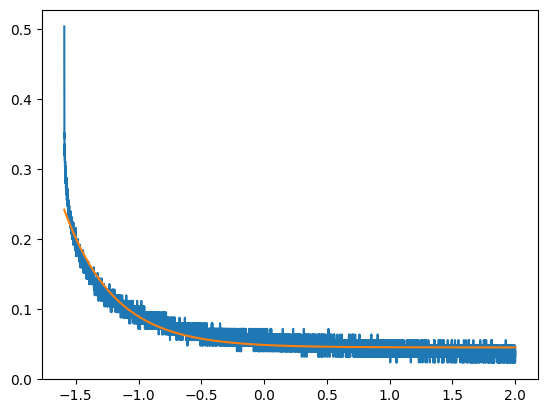

In [17]:
plt.plot(t_truncated, ch2_truncated)
plt.plot(t_truncated, model(t_truncated, A_model_truncated, RC_model_truncated, z_model_truncated))

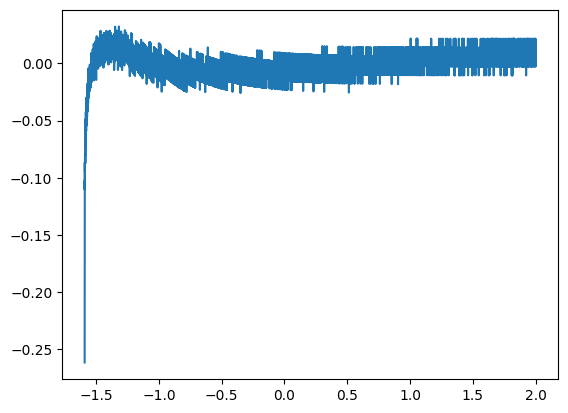

In [18]:
residual_truncated = model_truncated(t_truncated, A_model_truncated, RC_model_truncated, z_model_truncated) - ch2_truncated
plt.plot(t_truncated, residual_truncated)

In [19]:
t_trunc = np.array(t_truncated[residual_truncated == np.max(residual_truncated)])[0]

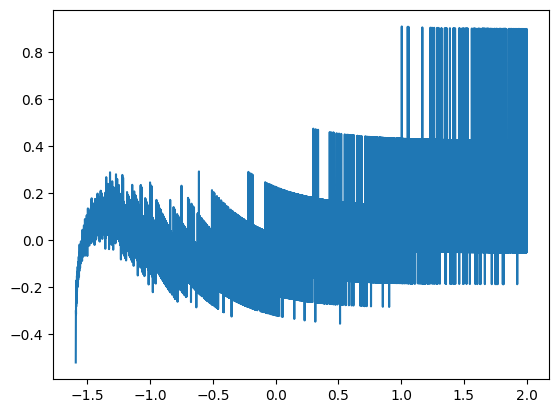

In [20]:
plt.plot(t_truncated, residual_truncated / ch2_truncated)

In [21]:
t_truncated2 = t[t>t_trunc]
ch2_truncated2 = ch2[t>t_trunc]
model_truncated2 = lambda t_truncated2, A, RC, z: A * np.exp(-t_truncated2/RC) + z
[A_model_truncated2, RC_model_truncated2, z_model_truncated2], cov_truncated2 = sp.optimize.curve_fit(model_truncated2, t_truncated2, ch2_truncated2)
cov_truncated2

array([[ 1.69081375e-09,  5.11763041e-08, -1.15245449e-09],
       [ 5.11763041e-08,  1.64464134e-06, -3.29555547e-08],
       [-1.15245449e-09, -3.29555547e-08,  1.03032957e-09]])

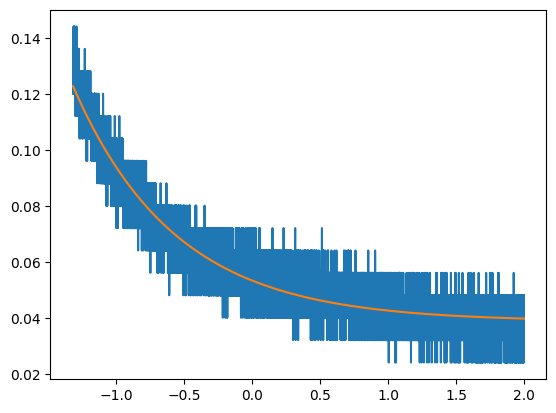

In [22]:
plt.plot(t_truncated2, ch2_truncated2)
plt.plot(t_truncated2, model(t_truncated2, A_model_truncated2, RC_model_truncated2, z_model_truncated2))

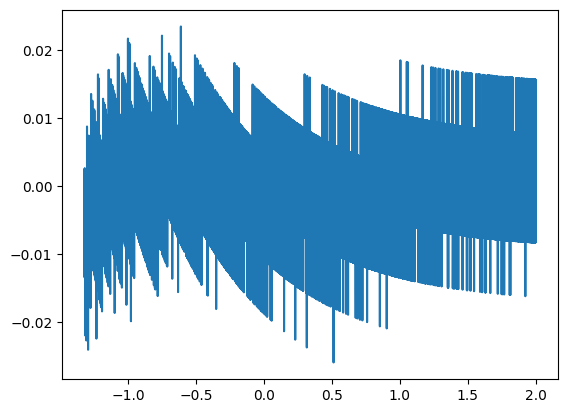

In [23]:
residual_truncated2 = model_truncated2(t_truncated2, A_model_truncated2, RC_model_truncated2, z_model_truncated2) - ch2_truncated2
plt.plot(t_truncated2, residual_truncated2)

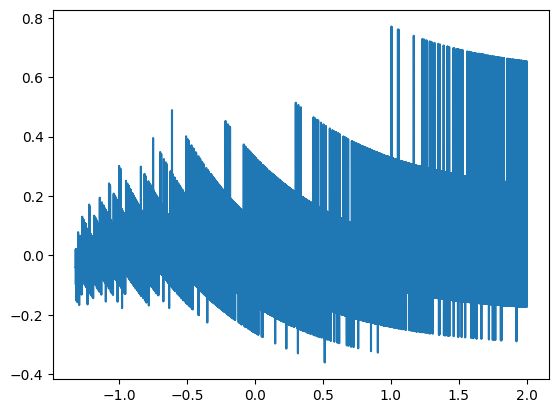

In [24]:
plt.plot(t_truncated2, residual_truncated2 / ch2_truncated2)

In [37]:
v_0 = 10
A_error = np.sqrt(cov[0,0]/t.size)
A_error_truncated = np.sqrt(cov_truncated[0,0]/t_truncated.size)
A_error_truncated2 = np.sqrt(cov_truncated2[0,0]/t_truncated2.size)
B_error = np.sqrt(cov[1,1]/t.size)
B_error_truncated = np.sqrt(cov_truncated[1,1]/t_truncated.size)
B_error_truncated2 = np.sqrt(cov_truncated2[1,1]/t_truncated2.size)
print("A:", A_model / v_0, "+-", A_error / v_0)
print("A-Truncated:", A_model_truncated / v_0, "+-", A_error_truncated / v_0)
print("A-Truncated2:", A_model_truncated2 / v_0, "+-", A_error_truncated2 / v_0)
print("B:", RC_model, "+-", B_error)
print("B-Truncated:", RC_model_truncated, "+-", B_error_truncated)
print("B-Truncated2:", RC_model_truncated2, "+-", B_error_truncated2)
z_error = np.sqrt(cov[2,2]/t.size)
print("z:", z_model, "+-", z_error)

A: 0.0003414263009811452 +- 6.158805791609884e-09
A-Truncated: 0.0003533524312464983 +- 5.583502705548551e-09
A-Truncated2: 0.0014597734467702642 +- 1.2768432029664686e-08
B: 0.39189736702590094 +- 1.894259487923439e-06
B-Truncated: 0.3959093734362693 +- 1.6942592718125697e-06
B-Truncated2: 0.753409791813049 +- 3.982220315109572e-06
z: 0.045614120909272846 +- 1.2659057380526664e-07


In [26]:
chi_squared = ((model(t, A_model, RC_model, z_model) - ch2)**2 / (0.004**2)).sum()
chi_squared_reduced = chi_squared / (t.size - 3)
print(chi_squared_reduced)

7.12302287049304


In [27]:
chi_squared_truncated = ((model_truncated(t_truncated, A_model_truncated, RC_model_truncated, z_model_truncated) - ch2_truncated)**2 / (0.004**2)).sum()
chi_squared_reduced_truncated = chi_squared_truncated / (t_truncated.size - 3)
print(chi_squared_reduced_truncated)

5.53184922351864


In [28]:
chi_squared_truncated2 = ((model_truncated2(t_truncated2, A_model_truncated2, RC_model_truncated2, z_model_truncated2) - ch2_truncated2)**2 / (0.004**2)).sum()
chi_squared_reduced_truncated2 = chi_squared_truncated2 / (t_truncated2.size - 3)
print(chi_squared_reduced_truncated2)

1.3355522487274565
